# Problem Sheet 6 - The CUR factorization

In this exercise we consider the CUR decomposition as a special case of the CX decomposition. For a matrix $A \in \mathbb{R}^{m,n}$ it is defined as $$A \approx C U R$$ with $C \in \mathbb{R}^{m,k}$, $U \in \mathbb{R}^{k,k}$ and $R \in \mathbb{R}^{k,n}$. The important idea is that $C$ contains columns of $A$ and $R$ contains rows of $A$.



We choose $k$ as the number of columns and rows we want to use and store the column and the row indices as vectors $p$ and $q$, respectively. The first test will be with a simple 4 by 3 matrix.

**Task: Given $p$ and $q$ recall from the lecture how to compute the intersection matrix $U$ and complete the following code.**

In [4]:
import numpy as np

A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]])
k = 2
p = np.array([0, 2])
q = np.array([1, 2])

def get_C(A, k, p):
    C = A[:, p[:k]]
    return C

def get_R(A, k, q):
    R = A[q[:k], :]
    return R

def get_U(A, C, R):
    C_inv = np.linalg.pinv(C)
    R_inv = np.linalg.pinv(R)
    U = C_inv @ A @ R_inv
    return U


C = get_C(A, k, p)
R = get_R(A, k, q)
U = get_U(A, C, R)


CUR = C @ U @ R

print(A)
print(CUR)

[[1 5 8]
 [3 9 1]
 [4 5 4]
 [0 9 2]]
[[4.9176025  5.02209156 5.34614024]
 [2.28517751 4.95894703 1.48423459]
 [4.49242566 7.78379344 3.66642133]
 [1.08414174 0.87889806 1.2655814 ]]


As you can see, we get an approximation of $A$, but we chose $p$ and $q$ randomly. In the following we want to implement the two heuristics for finding good values $p$ and $q$.  

The first heuristic is very simple - **leverage scores**.  Remember from the lecture that leverage scores are obtained via the truncated SVD.

**Task: Write a function that computes the row and column leverage scores and takes the matrix and a rank $k$ as input. The function should return the vectors $p$ and $q$.**

Hint: The truncated SVD is a scipy function, see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html). The numpy method argsort can also be helpful here.

In [6]:
from scipy.sparse.linalg import svds, eigs

def leverageScores(A, k):
   #Compute the singular value decomposition of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Compute the leverage scores for the rows
    row_leverage_scores = np.sum(np.abs(U[:, :k])**2, axis=1)
    
    # Compute the leverage scores for the columns
    col_leverage_scores = np.sum(np.abs(Vt.T[:, :k])**2, axis=1)
    
    return row_leverage_scores, col_leverage_scores
  
    return p, q

Test your function using the following code snippet.

In [7]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p, q = leverageScores(A, k) #your function here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct)

Your indices:
p =  [0.81806642 0.54263392 0.22682827 0.41247139]
q =  [0.05468382 0.95997569 0.98534048]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_leverage method that computes the CUR approximaton via leverage scores.** The function head should look like this:

```
CUR_leverage(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.



In [9]:
import numpy as np

def compute_leverage_scores(A, k):
    # Compute the singular value decomposition of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Compute the leverage scores for the rows
    row_leverage_scores = np.sum(np.abs(U[:, :k])**2, axis=1)
    
    # Compute the leverage scores for the columns
    col_leverage_scores = np.sum(np.abs(Vt.T[:, :k])**2, axis=1)
    
    return row_leverage_scores, col_leverage_scores

def select_top_k_indices(scores, k):
    # Select the top k indices with the highest scores
    return np.argsort(scores)[-k:]

def CUR_leverage(A, k):
    # Compute the leverage scores
    row_scores, col_scores = compute_leverage_scores(A, k)
    
    # Select the top k row and column indices
    p = select_top_k_indices(row_scores, k)
    q = select_top_k_indices(col_scores, k)
    
    # Compute the C, U, and R matrices
    C = A[:, p]
    R = A[q, :]
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return C, U, R

A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]])
k = 2
C, U, R = CUR_leverage(A, k)

print("C matrix:")
print(C)
print("U matrix:")
print(U)
print("R matrix:")
print(R)


C matrix:
[[5 1]
 [9 3]
 [5 4]
 [9 0]]
U matrix:
[[ 0.10290662 -0.00096635]
 [-0.10430732  0.21179207]]
R matrix:
[[3 9 1]
 [4 5 4]]


Let's look at the absolute and relative $\ell_2$ error.

In [10]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_leverage(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  7.937991275852156
relative error:  0.4416816495538918


Now, we want to implement the second heuristic based on projections. 

**Task: Implement the DEIM algorithm to compute $p$ from the lecture and use the same concept to implement an algorithm for $q$.**

Hint: you can also check out Algorithm 1 in [this paper](https://arxiv.org/pdf/1407.5516.pdf).

In [24]:
import numpy as np

def DEIM(M, k):
    U, _, _ = np.linalg.svd(M, full_matrices=False)
    p = []
    p.append(np.argmax(np.abs(U[:,0])))
    
    for i in range(1, U.shape[1]):
        r = U[:,i].copy()
        for j in range(i):
            r -= np.dot(U[:,i], U[:,p[j]]) * U[:,p[j]]
        p.append(np.argmax(np.abs(r)))
        
    return np.array(p)

def DEIM_q(M, k):
    _, _, Vt = np.linalg.svd(M, full_matrices=False)
    q = []
    q.append(np.argmax(np.abs(Vt[0,:])))
    
    for i in range(1, Vt.shape[0]):
        r = Vt[i,:].copy()
        for j in range(i):
            r -= np.dot(Vt[i,:], Vt[q[j],:]) * Vt[q[j],:]
        q.append(np.argmax(np.abs(r)))
        
    return np.array(q)

# compute p and q for a given matrix A
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]])
p = DEIM(A, k)
q = DEIM_q(A, k)

print("p:", p)
print("q:", q)


p: [1 0 2]
q: [1 2 0]


Test the algorithm on the following example as before.

In [25]:
# compute p and q for a given matrix A
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p = DEIM(A, k) 
q = DEIM_q(A, k) # corrected typo here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct)


Your indices:
p =  [1 0 2]
q =  [1 2 0]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_deim method that computes the CUR approximaton via the projection approach.** The function head should look like this:

```
CUR_deim(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.

In [26]:
def DEIM(M, k):
    U, _, _ = np.linalg.svd(M, full_matrices=False)
    p = []
    p.append(np.argmax(np.abs(U[:,0])))
    
    for i in range(1, k):
        r = U[:,i].copy()
        for j in range(i):
            r -= np.dot(U[:,i], U[:,p[j]]) * U[:,p[j]]
        p.append(np.argmax(np.abs(r)))
        
    return np.array(p)

def DEIM_q(M, k):
    _, _, Vt = np.linalg.svd(M, full_matrices=False)
    q = []
    q.append(np.argmax(np.abs(Vt[0,:])))
    
    for i in range(1, k):
        r = Vt[i,:].copy()
        for j in range(i):
            r -= np.dot(Vt[i,:], Vt[q[j],:]) * Vt[q[j],:]
        q.append(np.argmax(np.abs(r)))
        
    return np.array(q)

def get_C(A, k, p):
    C = A[:, p[:k]]
    return C

def get_R(A, k, q):
    R = A[q[:k], :]
    return R

def get_U(A, C, R):
    C_inv = np.linalg.pinv(C)
    R_inv = np.linalg.pinv(R)
    U = C_inv @ A @ R_inv
    return U

def CUR_deim(A, k):
    p = DEIM(A, k) 
    q = DEIM_q(A, k)
    
    C = get_C(A, k, p)
    R = get_R(A, k, q)
    U = get_U(A, C, R)
    
    return C, U, R

# Testing
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2

C, U, R = CUR_deim(A, k)
print("C = ", C)
print("U = ", U)
print("R = ", R)


C =  [[5. 1.]
 [9. 3.]
 [5. 4.]
 [9. 0.]]
U =  [[ 0.10290662 -0.00096635]
 [-0.10430732  0.21179207]]
R =  [[3. 9. 1.]
 [4. 5. 4.]]


Let's look at the absolute and relative $\ell_2$ error.

In [27]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_deim(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  7.937991275852156
relative error:  0.4416816495538918


# Applications

Having implemented both CUR variants, we want to apply and compare them on different examples. The first example is an RGB image of a baboon that we transform into a grayscale image to make it applicable to a CUR decomposition. Execute the following code to visualize the original image and the two CUR approximations. Which one looks better?

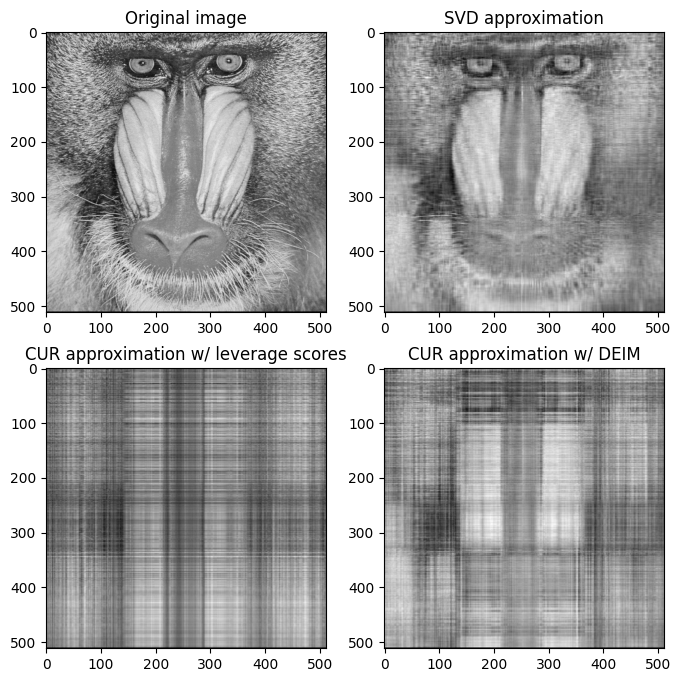

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

k = 20

im = np.asarray(Image.open('baboon.png').convert('L'), dtype=float)

U, S, Vt = svds(im, k=k)

C1, U1, R1 = CUR_leverage(im,k)
C2, U2, R2 = CUR_deim(im,k)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Original image')
plt.imshow(im, cmap='gray')
plt.subplot(222)
plt.imshow((U@np.diag(S)@Vt), cmap='gray')
plt.title('SVD approximation')
plt.subplot(223)
plt.imshow((C1@U1@R1), cmap='gray')
plt.title('CUR approximation w/ leverage scores')
plt.subplot(224)
plt.imshow((C2@U2@R2), cmap='gray')
plt.title('CUR approximation w/ DEIM')
plt.show()

Feel free to upload images of your own and try the CUR approximation with it. 

Additional Task: Apply the CUR factorization to the supreme court data set.